# _Notebook for re-subclass labeling Slide 2 MFs (train), Frederick Lee, M.D._
### *2022_11_16_fsl*
_...now with much more subclassing experience, want to circle back to the first slide subclassed, check for consistency, and update subclass labels as necessary on all 64 MF annotations for this slide..._

# 1. Setup:
* Connect drive
* Turn off cell scrolling in Jupyter notebook
* Install openslide
* Install SlideRunner  

### _NB: for this notebook (slide_2) chose to reduce image patch presented for subclassing to 64 px, plt image size to 6,6; this has no impact on the output .csv subclassing files._  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
!apt-get install openslide-tools python3-openslide

<IPython.core.display.Javascript object>

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  javascript-common libjs-jquery libopenslide0 python-asn1crypto
  python-blinker python-cffi-backend python-click python-colorama
  python-cryptography python-enum34 python-flask python-idna python-ipaddress
  python-itsdangerous python-jinja2 python-markupsafe
  python-openslide-examples python-openssl python-pkg-resources
  python-pyinotify python-simplejson python-six python-werkzeug
  python3-olefile python3-pil
Suggested packages:
  apache2 | lighttpd | httpd libtiff-tools python-blinker-doc
  python-cryptography-doc python-cryptography-vectors python-enum34-doc
  python-flask-doc python-jinja2-doc python-openssl-doc python-openssl-dbg
  python-setuptools python-pyinotify-doc ipython python-genshi pyt

In [ ]:
!python -m pip install -U SlideRunner

<IPython.core.display.Javascript object>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511 kB 4.7 MB/s 
     |████████████████████████████████| 8.4 MB 73.8 MB/s 
     |████████████████████████████████| 98 kB 7.9 MB/s 
     |████████████████████████████████| 2.0 MB 72.5 MB/s 
     |████████████████████████████████| 59.9 MB 2.5 MB/s 
     |████████████████████████████████| 344 kB 88.7 MB/s 


In [ ]:
# get demo slide:
# import urllib.request
# urllib.request.urlretrieve('https://ndownloader.figshare.com/files/16261553?private_link=a82ddb634864c24f4aee','9374efe6ac06388cc877.svs')

<IPython.core.display.Javascript object>

# 2. Get image patches for subclassing:  

Use the published __MEL sqlite db__ to view, choose, and subclass patches for Rajiv's Resnet ingestion, subclassifier model training, label propagation, testing, etc.:  
  
*  __Patches are dim 128 × 128 px and were:__  
    *  drawn from across ***all train slides*** 
    *  chosen as ***clear (unambiguous) examples*** of the assigned subclass,    
    *  with target of ~20 labeled patches per sublcass (× 6 subclasses = 120 patches total for initial train run)  
    *  **NB: Patches were _centered_ about the (x1, y1) coordinates provided in the sqlite db; these coordinates indicate the annotation center.**    

* __Patch subclass labels were assigned as:__  
    **1** — ***NOT used*** (reserved  as published for MLF = 'mitotic-like figure', 'hard negative', 'imposter')   
    **2** — ***NOT used*** (reserved as published for MF = 'mitotic figure')  
    **3** — ***prometaphase (PM)***  
    **4** — ***metaphase (MP)***  
    **5** — ***metaphase, rosette (MR)***   
    **6** — ***anaphase (AP), telophase (TP) (COMBINED)***  
    **7** — ***atypical mitotic figure (AMF)***   
    **8** — ***non-mitotic figure (MLF):*** same as authors' _class '1'_ above  
    **0** — ***SKIP THIS ANNOTATION (AMBIGUOUS SUBCLASS)*** 


## _a. Set gdrive paths, train/test slides & filenames:_

In [ ]:
# set path to local canine data:
path_can = 'drive/MyDrive/sam/code/dat/'

<IPython.core.display.Javascript object>

In [ ]:
# create dictionary of slide no.'s & .svs filenames as specified in PUBLISHED PAPER
# (NB: Slide no.'s in sqlite MEL db DON'T necessarily match slide no. and .svs 
# filename in published paper!)

# by manual entry:
slide_dict = {1: '4eee7b944ad5e46c60ce',
              2: 'a8773be388e12df89edd',
              3: 'deb768e5efb9d1dcbc13',
              4: 'e09512d530d933e436d5',
              5: '72c93e042d0171a61012',
              6: '2d56d1902ca533a5b509',
              7: '084383c18b9060880e82',
              8: 'da18e7b9846e9d38034c',
              9: '13528f1921d4f1f15511',
              10: 'd0423ef9a648bb66a763',
              11: '69a02453620ade0edefd',
              12: 'd37ab62158945f22deed',
              13: 'd7a8af121d7d4f3fbf01',
              14: '460906c0b1fe17ea5354',
              15: 'b1bdee8e5e3372174619',
              16: 'c4b95da36e32993289cb',
              17: '022857018aa597374b6c',
              18: '50cf88e9a33df0c0c8f9',
              19: '3d3d04eca056556b0b26',
              20: '2191a7aa287ce1d5dbc0',
              21: 'fa4959e484beec77543b'}

# create sub-dict. for train slides:
train_slide_l = [2, 3, 5, 7, 8, 10, 12, 13, 14, 16, 18, 19, 20, 21]
train_dict = {x: slide_dict[x] for x in train_slide_l}
assert len(train_dict) == 14

# create sub-dict. for test slides:
test_slide_l = [x for x in range(1,22) if x not in train_slide_l]
test_dict = {x: slide_dict[x] for x in test_slide_l}
assert len(test_dict) == 7

# verify above manually typed-in slide filenames
# via copy-pasting filenames directly from pdf of published paper:
pdf_slide_l = ['4eee7b944ad5e46c60ce',
               'a8773be388e12df89edd',
               'deb768e5efb9d1dcbc13',
               'e09512d530d933e436d5',
               '72c93e042d0171a61012',
               '2d56d1902ca533a5b509',
               '084383c18b9060880e82',
               'da18e7b9846e9d38034c',
               '13528f1921d4f1f15511',
               'd0423ef9a648bb66a763',
               '69a02453620ade0edefd',
               'd37ab62158945f22deed',
               'd7a8af121d7d4f3fbf01',
               '460906c0b1fe17ea5354',
               'b1bdee8e5e3372174619',
               'c4b95da36e32993289cb',
               '022857018aa597374b6c',
               '50cf88e9a33df0c0c8f9',
               '3d3d04eca056556b0b26',
               '2191a7aa287ce1d5dbc0',
               'fa4959e484beec77543b']

for item in slide_dict.keys():
    if slide_dict[item] == pdf_slide_l[item - 1]:
        print(f'slide {item:2d}, filename: {slide_dict[item]} is a  match!')
    else:
        assert slide_dict[item] == pdf_slide_l[item - 1]

<IPython.core.display.Javascript object>

slide  1, filename: 4eee7b944ad5e46c60ce is a  match!
slide  2, filename: a8773be388e12df89edd is a  match!
slide  3, filename: deb768e5efb9d1dcbc13 is a  match!
slide  4, filename: e09512d530d933e436d5 is a  match!
slide  5, filename: 72c93e042d0171a61012 is a  match!
slide  6, filename: 2d56d1902ca533a5b509 is a  match!
slide  7, filename: 084383c18b9060880e82 is a  match!
slide  8, filename: da18e7b9846e9d38034c is a  match!
slide  9, filename: 13528f1921d4f1f15511 is a  match!
slide 10, filename: d0423ef9a648bb66a763 is a  match!
slide 11, filename: 69a02453620ade0edefd is a  match!
slide 12, filename: d37ab62158945f22deed is a  match!
slide 13, filename: d7a8af121d7d4f3fbf01 is a  match!
slide 14, filename: 460906c0b1fe17ea5354 is a  match!
slide 15, filename: b1bdee8e5e3372174619 is a  match!
slide 16, filename: c4b95da36e32993289cb is a  match!
slide 17, filename: 022857018aa597374b6c is a  match!
slide 18, filename: 50cf88e9a33df0c0c8f9 is a  match!
slide 19, filename: 3d3d04ec

## _b. Select slide for viewing candidate patches for subclassing:_  

In [ ]:
# test input fxn in google colab:
test_input = input('Please enter any test input: ')
print(test_input)

<IPython.core.display.Javascript object>

Please enter any test input: 242
242


In [ ]:
# define fxn to get valid user input in val_range; return as val_type:
def read_val(val_type, val_range, request_msg, error_msg):
    while True:
        val = input(request_msg + ' ')
        try:
            assert val_type(val) in val_range
            return val_type(val)
        except (ValueError, AssertionError) as error:
            print(val, error, error_msg)

<IPython.core.display.Javascript object>

In [ ]:
# select slide no to view:
request_msg = f'Enter train slide no. to select:'
error_msg = f'Invalid slide no. (e.g., not a train slide); try again...\n'

slide_no = read_val(int, train_slide_l, request_msg, error_msg)
print(f'\nOK, selecting train slide {slide_no:2d}, '
      f'.svs filename: {train_dict[slide_no]}....')

<IPython.core.display.Javascript object>

Enter train slide no. to select: 2

OK, selecting train slide  2, .svs filename: a8773be388e12df89edd....


## _c. Load ***MEL*** sqlite db, chosen training slide, and published annotations:_

In [ ]:
# load published MEL sqlite db:
from SlideRunner.dataAccess.database import Database
DB = Database().open(path_can + 'annot/MITOS_WSI_CMC_MEL.sqlite')

# set slide image filename:
slide_svs = train_dict[slide_no]

slideid = DB.findSlideWithFilename(path_can + 'WSI/train/' + slide_svs + '.svs','')
DB.loadIntoMemory(slideid)

# list all the train slide annotations:
print(f'The published annots. for slide {slide_no:2d} {slide_svs + ".svs"} are:\n\n')

# (while listing annots., check if all are class spotAnnotations):
spot_annots = True

for annot in DB.annotations.keys():
    print(f'annot. {annot:5d}: {DB.annotations[annot]}, {type(DB.annotations[annot])}')

<IPython.core.display.Javascript object>

The published annots. for slide  2 a8773be388e12df89edd.svs are:


annot.     1: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f4e8a2d1fd0>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     2: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f4e8a2d1dd0>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     3: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f4e8a2d1510>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     4: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f4e8a2d1910>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     5: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f4e8a2d1650>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     6: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f4e8a2d1590>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     7: <SlideR

## _d. Verify counts of slide annotations retrieved from ***MEL sqlite db*** with published numbers:_

In [ ]:
# store PUBLISHED counts for MEL annotations in a dictionary with
# keys = slide no. in PUBLISHED paper
# values = tuple (no. MF's in MEL, no. MLF's in MEL):

slide_counts = {1: [47, 114],
                2: [64, 204],
                3: [92, 287],
                4: [87, 602],
                5: [130, 375],
                6: [139, 228],
                7: [157, 404],
                8: [187, 991],
                9: [283, 963],
                10: [378, 1143],
                11: [634, 1407],
                12: [578, 1105],
                13: [716, 1832],
                14: [673, 1199],
                15: [812, 1260],
                16: [1097, 2454],
                17: [1290, 2463],
                18: [1197, 1632],
                19: [1383, 2110],
                20: [1449, 2155],
                21: [1949, 3598]}

<IPython.core.display.Javascript object>

In [ ]:
# verify total number of annotations
assert len(DB.annotations) == sum(slide_counts[slide_no])

print(f'Σ no. annots. for slide no. {slide_no:2d} '
      f'verified as {len(DB.annotations):4d}')

# verify total annots. with agreedClass = '1' (MLF, mitotic-like figure)
# or with agreedClass = '2' (MF, mitotic figure):
annot_cl1_l = [] # list of agreedClass '1' annot. keys
annot_cl2_l = [] # list of agreedClass '2' annot. keys

for key in DB.annotations.keys():
    if DB.annotations[key].agreedClass == 1:
        annot_cl1_l.append(DB.annotations[key])
    else:
        assert DB.annotations[key].agreedClass == 2
        annot_cl2_l.append(DB.annotations[key])

assert len(annot_cl1_l) == slide_counts[slide_no][1] # verify no. MLFs
print(f'Σ no. CLASS1 (MLF) annots. for slide no. {slide_no:2d} '
      f'verified as {len(annot_cl1_l):4d}')

assert len(annot_cl2_l) == slide_counts[slide_no][0] #verify no. MFs
print(f'Σ no. CLASS2 (MF)  annots. for slide no. {slide_no:2d} '
      f'verified as {len(annot_cl2_l):4d}')

<IPython.core.display.Javascript object>

Σ no. annots. for slide no.  2 verified as  268
Σ no. CLASS1 (MLF) annots. for slide no.  2 verified as  204
Σ no. CLASS2 (MF)  annots. for slide no.  2 verified as   64


## _e. Check attributes available for an example annot. in `DB.annotations` dict. and choose relevant attributes:_  
Before listing, _remove:_  
*  dunders & sunders  
*  callables  

_see v3 of this subclassing Jn for detailed exploration of DB.annotations objects & attributes_

In [ ]:
# look at DB.annotations object:
print(len(DB.annotations), type(DB.annotations), annot)

<IPython.core.display.Javascript object>

268 <class 'dict'> 30134


In [ ]:
# selected, available attributes of annots. in DB.annotations dict.:
# NB: look at just one DB.annotations dictionary entry & query its available
# attributes for later use below; for convenience, we will choose the last
# dict. entry (which should be given by the for loop counter variable 'annot'
# used above)
DBannot_attr = [a for a in dir(DB.annotations[annot]) \
                if not (a.startswith('__') or a.startswith('_')) \
                and (not callable(getattr(DB.annotations[annot], a)))]

# example object instance attributes left after above filtering:
print(*DBannot_attr, sep='\n')

<IPython.core.display.Javascript object>

agreedClass
annotationType
clickable
coordinates
deleted
guid
labels
lastModified
minimumAnnotationLabelZoom
pluginAnnotationLabel
r
text
uid
x1
y1
zLevel


In [ ]:
# remove following uninformative attributes:
#    'annotationType'
#    'clickable'
#    'deleted'
#    'labels'
#    'lastModified'
#    'minimumAnnotationLabelZoom
#    'pluginAnnotationLabel'
#    'r'
#    'text'
#    'zlevel'

DBannot_attr = [x for x in DBannot_attr if x not in ['annotationType', \
                     'clickable', 'deleted', 'labels', 'lastModified', \
                     'minimumAnnotationLabelZoom', 'pluginAnnotationLabel', 
                     'r', 'text', 'zLevel']]

print(*DBannot_attr, sep='\n')

<IPython.core.display.Javascript object>

agreedClass
coordinates
guid
uid
x1
y1


## _f. Store selected attributes for all slide annots. in pandas df:_

In [ ]:
# initialize lists for selected attributes of slide annots. to build
# annot. df:
key_l = []    # DB.annotations dict. key
uid_l = []    # annot. uid attr.
ctr_l = []    # annot. center coord. (from annot. x1, y1 attr.)
coord_l = []  # annot. coords. attr. (gives left upper & right lower corner
              #     coord. of 50 × 50 px annot. box surrounding center coord.)
lbl_l = []    # annot. agreedClass attr.
guid_l = []   # annot. guid attr.

# create a view object of slide annotations dict.
d_items = DB.annotations.items()

# store selected attribs. for ea. slide annot. in above attr. lists:
for item in d_items:
    key_l.append(item[0])
    uid_l.append(item[1].uid)
    ctr_l.append([item[1].x1, item[1].y1])
    coord_l.append(item[1].coordinates)
    lbl_l.append(item[1].agreedClass)
    guid_l.append(item[1].guid)

<IPython.core.display.Javascript object>

### _i. dataframe of all annots. for slide in original sqlite order_

In [ ]:
# store selected attribs for slide annots in df:
import pandas as pd

annot_df = pd.DataFrame(list(zip(
    key_l, uid_l, ctr_l, coord_l, lbl_l, guid_l)), columns =
    ['key', 'uid', 'ctr', 'coord', 'lbl', 'guid'])

# view df:
#     set pd display options:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 7)

annot_df

<IPython.core.display.Javascript object>

,key,uid,ctr,coord,lbl,guid
0,1,1,"[21029, 7246]","[[21004, 7221], [21054, 7271]]",1,05535b17-a3f3-48f9-ae21-dbf9617efcf1
1,2,2,"[21030, 7305]","[[21005, 7280], [21055, 7330]]",1,b1c70dda-71fc-4444-ace1-d2dbf7ce9149
2,3,3,"[20378, 6976]","[[20353, 6951], [20403, 7001]]",1,846da71e-d894-4018-9c23-a0472781a699
3,4,4,"[21086, 6940]","[[21061, 6915], [21111, 6965]]",1,eea842e0-5739-4143-995f-13053cfb8dfa
4,5,5,"[23504, 7623]","[[23479, 7598], [23529, 7648]]",1,1c886987-f274-440d-bf8b-9369ef9f6847
5,6,6,"[15300, 8437]","[[15275, 8412], [15325, 8462]]",1,c6ffc256-a24d-4f1c-b951-db79e0928719
6,7,7,"[24069, 8282]","[[24044, 8257], [24094, 8307]]",1,86c3e10c-4adf-4765-9c34-86ce3ede8d0c
7,8,8,"[14561, 9753]","[[14536, 9728], [14586, 9778]]",1,93897268-c222-4f52-9897-14f9f2708da7
8,9,9,"[14607, 9443]","[[14582, 9418], [14632, 9468]]",1,4c711ecb-3aaf-49c6-849f-4e81eb4d79e3
9,10,10,"[15481, 9406]","[[15456, 9381], [15506, 9431]]",1,bf764c0d-ebc1-4eaa-b763-0ab2e2e4d163


In [ ]:
# save annot_df to csv:
#     (add date-time stamp to filename)
# import time
# timestr = time.strftime("%-y%-d%-m-%-S%-M%-H")

annot_df.to_csv('drive/MyDrive/sam/subcl/slide_2/re-subclass (2022_11_16)/' + '20221116-115200' +
                '_ann_df_sl_' + str(slide_no) + '_ori_unsorted.csv')

<IPython.core.display.Javascript object>

### _ii. Sorted annotation dataframe for viewing/subclassing patches:_

In [ ]:
# sort annot_df by lbl:
annot_df_sorted = annot_df.sort_values(by='lbl', axis=0, ascending=False)

annot_df_sorted

<IPython.core.display.Javascript object>

,key,uid,ctr,coord,lbl,guid
134,144,144,"[39154, 38931]","[[39129, 38906], [39179, 38956]]",2,55769705-b5df-4669-bd4a-6abb782c05e9
110,116,116,"[41841, 35854]","[[41816, 35829], [41866, 35879]]",2,37da286e-c719-4e2e-8c28-5106279c8745
104,109,109,"[43709, 35008]","[[43684, 34983], [43734, 35033]]",2,aac4e2fa-c1ad-42f4-b139-c9b7d5b3696b
188,1396,1396,"[14790, 34067]","[[14765, 34042], [14815, 34092]]",2,47118562-d433-49d2-9c72-b0c1fa5242ea
101,106,106,"[23996, 35202]","[[23971, 35177], [24021, 35227]]",2,d819ba1a-ff85-40bd-8e39-faf42117c8a4
100,105,105,"[14293, 34679]","[[14268, 34654], [14318, 34704]]",2,8d2b7434-407e-4d3f-b61b-fceb0b27d5c6
99,104,104,"[11166, 35831]","[[11141, 35806], [11191, 35856]]",2,7e538efe-7c4c-4f7b-8f22-c10d61c27366
98,103,103,"[11153, 35690]","[[11128, 35665], [11178, 35715]]",2,6a856710-6ab3-4807-99cb-659e8b9d6ae3
97,102,102,"[10910, 35820]","[[10885, 35795], [10935, 35845]]",2,2c7ad1c8-1293-4a4b-b651-9335d438fbb3
94,99,99,"[7746, 34679]","[[7721, 34654], [7771, 34704]]",2,0b1511e8-a58e-4e54-9265-65ac68d9c5de


## _g. Load slide 2 .svs image and loop through 64 x 64 px patches using above `annot_df`:_  

In [ ]:
# load slide .svs image:
import openslide

print(f'Loading slide no. {slide_no:2d} image file: {train_dict[slide_no] + ".svs...."}')
slide = openslide.open_slide(path_can + 'WSI/train/' + 
    train_dict[slide_no] + '.svs')

<IPython.core.display.Javascript object>

Loading slide no.  2 image file: a8773be388e12df89edd.svs....


<IPython.core.display.Javascript object>

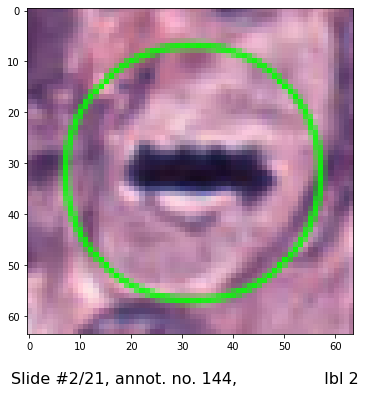

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

0 of 64 patches subclassed; 64 left to go!



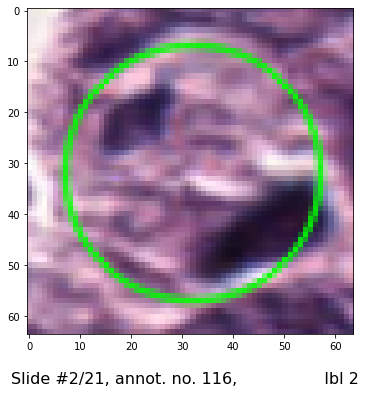

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

1 of 64 patches subclassed; 63 left to go!



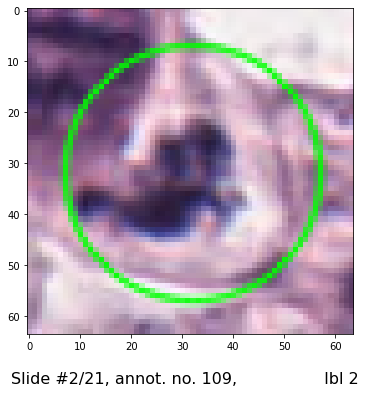

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

2 of 64 patches subclassed; 62 left to go!



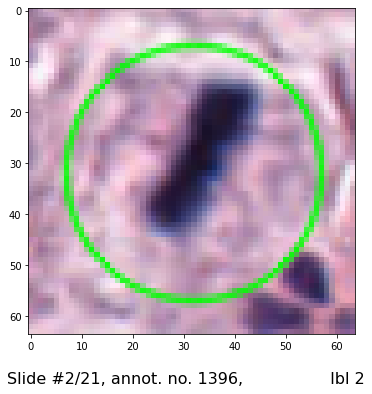

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

3 of 64 patches subclassed; 61 left to go!



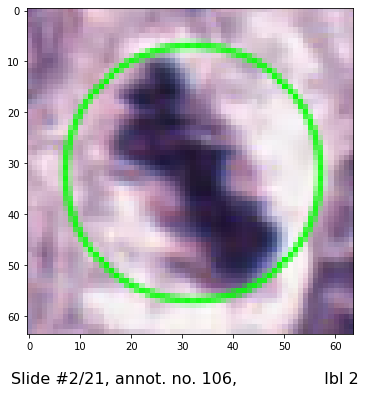

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

4 of 64 patches subclassed; 60 left to go!



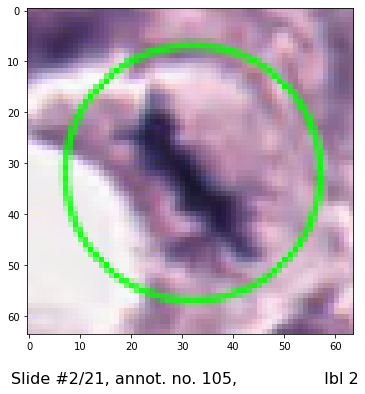

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

5 of 64 patches subclassed; 59 left to go!



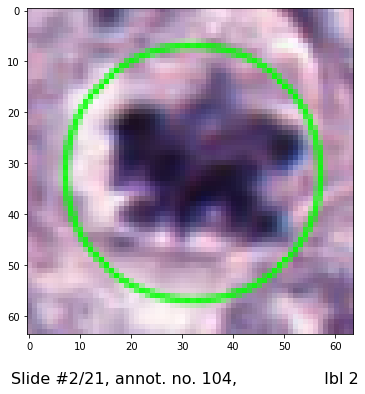

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

6 of 64 patches subclassed; 58 left to go!



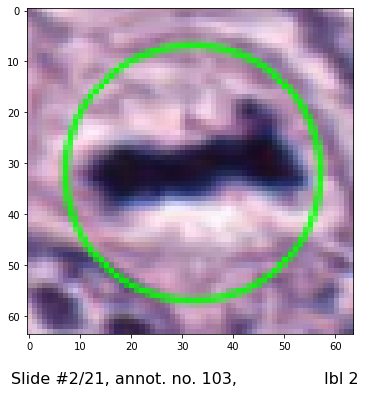

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

7 of 64 patches subclassed; 57 left to go!



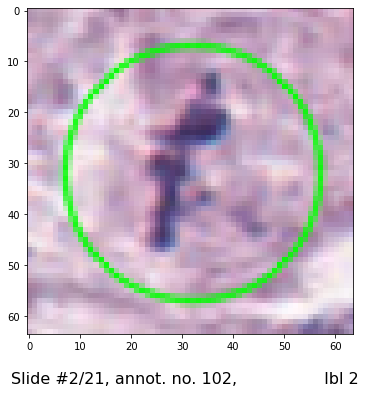

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

8 of 64 patches subclassed; 56 left to go!



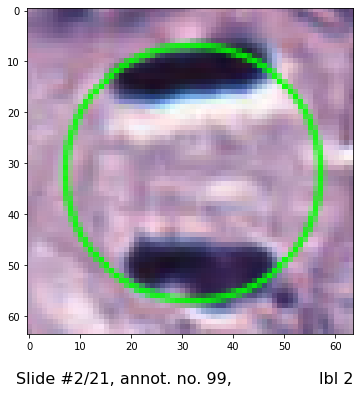

Subclass label?  6


OK, confirming user subclass label =    6 written to annotation dataframe....

9 of 64 patches subclassed; 55 left to go!



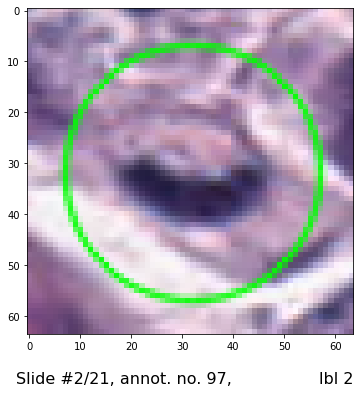

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

10 of 64 patches subclassed; 54 left to go!



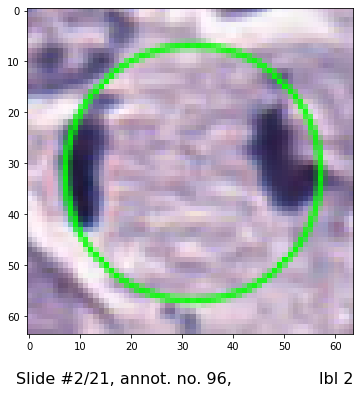

Subclass label?  6


OK, confirming user subclass label =    6 written to annotation dataframe....

11 of 64 patches subclassed; 53 left to go!



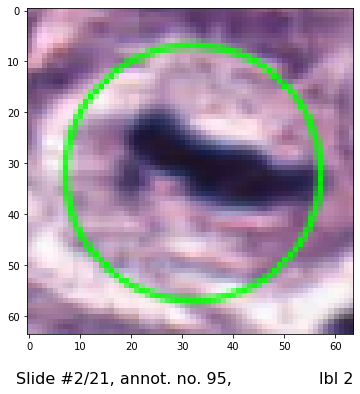

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

12 of 64 patches subclassed; 52 left to go!



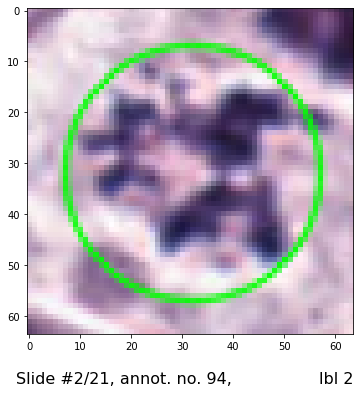

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

13 of 64 patches subclassed; 51 left to go!



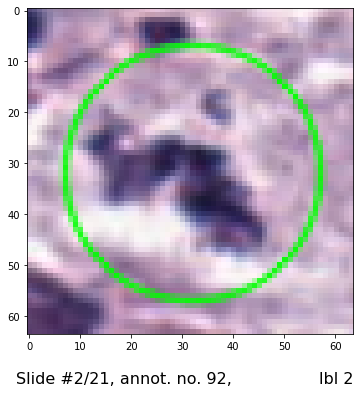

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

14 of 64 patches subclassed; 50 left to go!



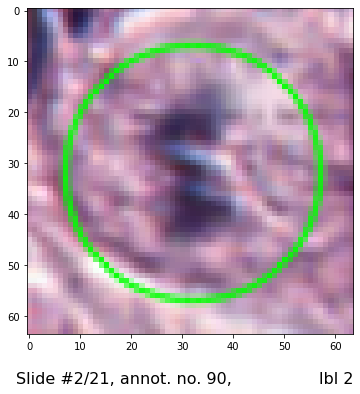

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

15 of 64 patches subclassed; 49 left to go!



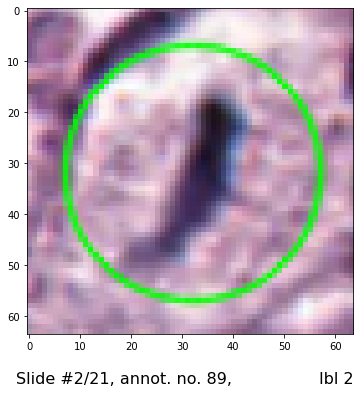

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

16 of 64 patches subclassed; 48 left to go!



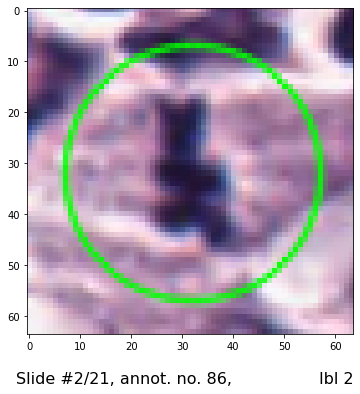

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

17 of 64 patches subclassed; 47 left to go!



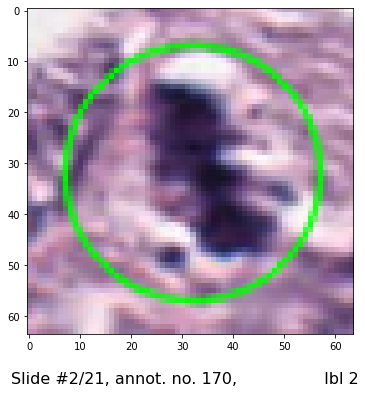

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

18 of 64 patches subclassed; 46 left to go!



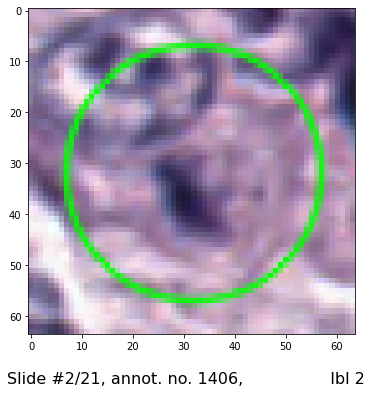

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

19 of 64 patches subclassed; 45 left to go!



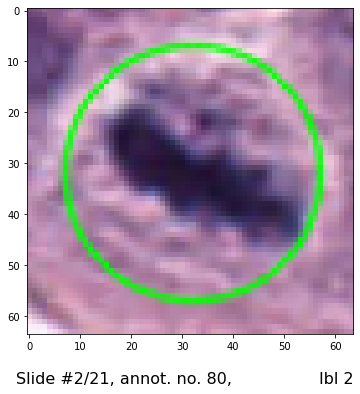

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

20 of 64 patches subclassed; 44 left to go!



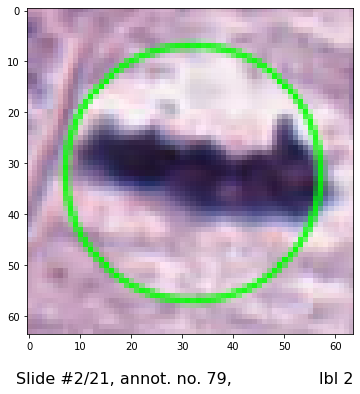

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

21 of 64 patches subclassed; 43 left to go!



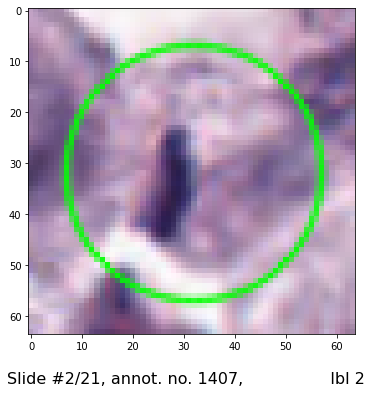

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

22 of 64 patches subclassed; 42 left to go!



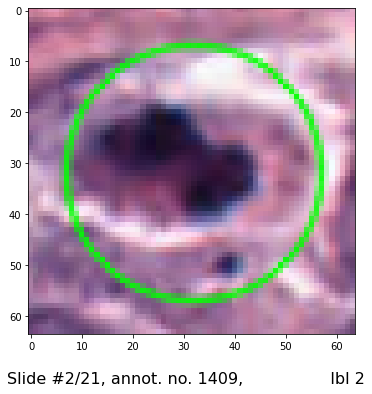

Subclass label?  6


OK, confirming user subclass label =    6 written to annotation dataframe....

23 of 64 patches subclassed; 41 left to go!



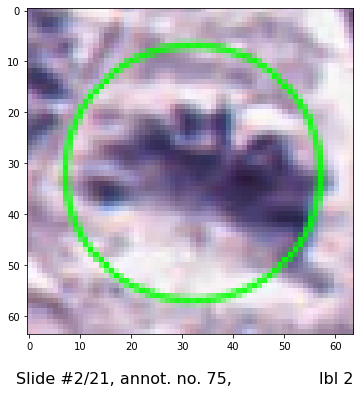

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

24 of 64 patches subclassed; 40 left to go!



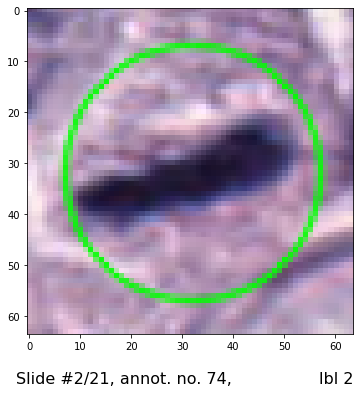

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

25 of 64 patches subclassed; 39 left to go!



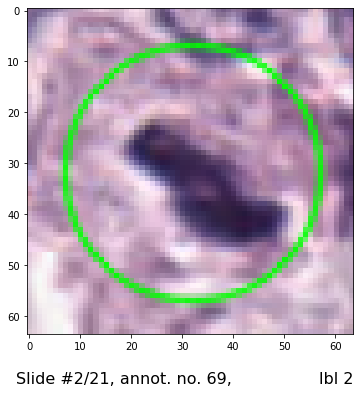

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

26 of 64 patches subclassed; 38 left to go!



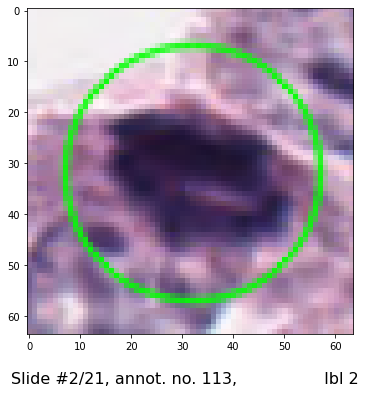

Subclass label?  5


OK, confirming user subclass label =    5 written to annotation dataframe....

27 of 64 patches subclassed; 37 left to go!



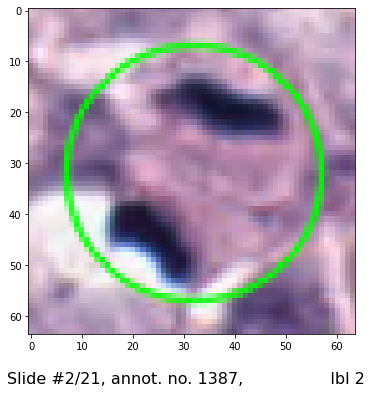

Subclass label?  6


OK, confirming user subclass label =    6 written to annotation dataframe....

28 of 64 patches subclassed; 36 left to go!



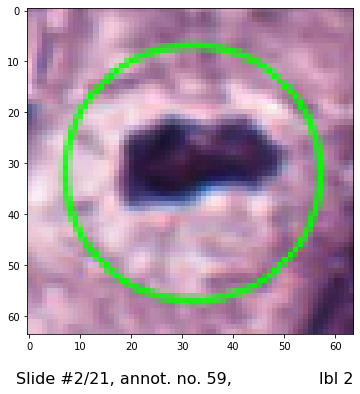

Subclass label?  5


OK, confirming user subclass label =    5 written to annotation dataframe....

29 of 64 patches subclassed; 35 left to go!



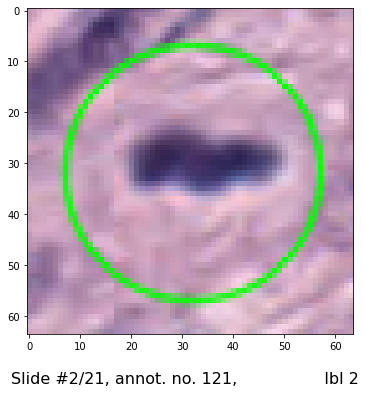

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

30 of 64 patches subclassed; 34 left to go!



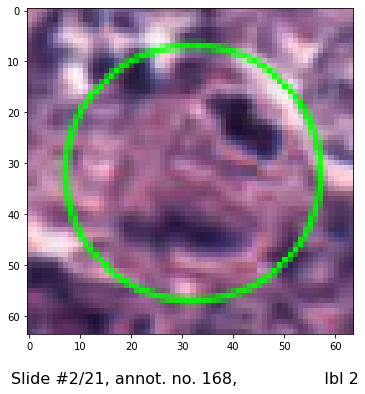

Subclass label?  6


OK, confirming user subclass label =    6 written to annotation dataframe....

31 of 64 patches subclassed; 33 left to go!



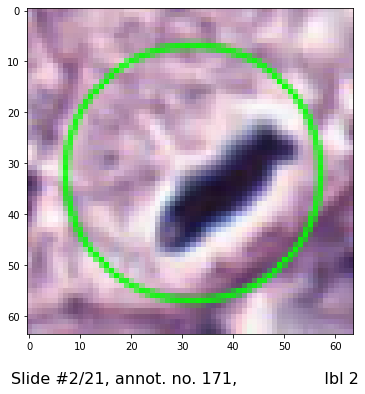

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

32 of 64 patches subclassed; 32 left to go!



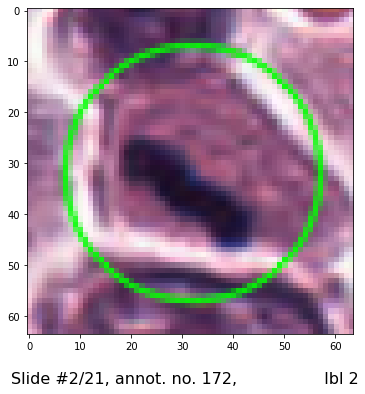

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

33 of 64 patches subclassed; 31 left to go!



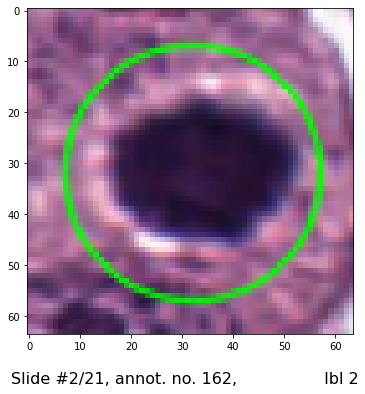

Subclass label?  3


OK, confirming user subclass label =    3 written to annotation dataframe....

34 of 64 patches subclassed; 30 left to go!



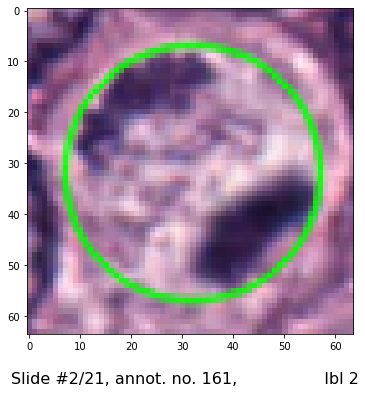

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

35 of 64 patches subclassed; 29 left to go!



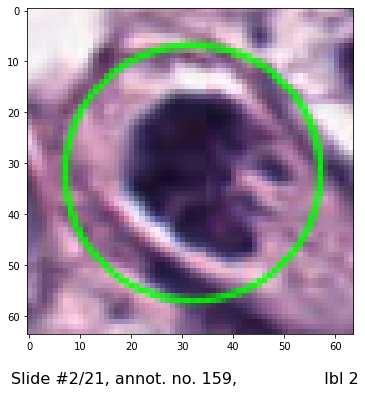

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

36 of 64 patches subclassed; 28 left to go!



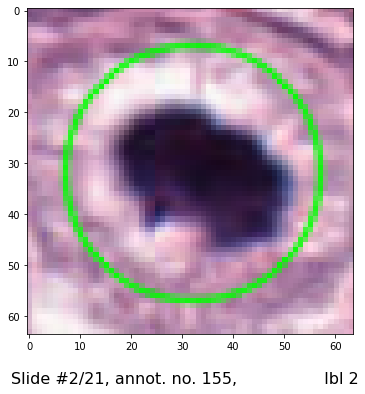

Subclass label?  0


OK, confirming user subclass label =    0 written to annotation dataframe....

37 of 64 patches subclassed; 27 left to go!



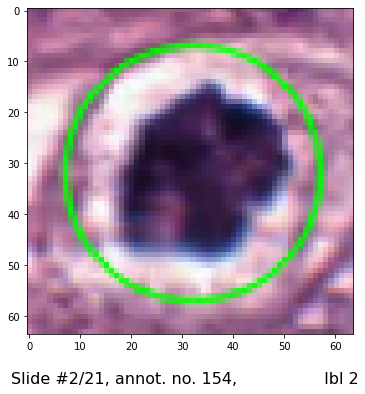

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

38 of 64 patches subclassed; 26 left to go!



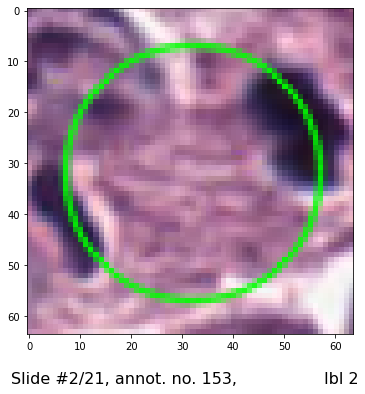

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

39 of 64 patches subclassed; 25 left to go!



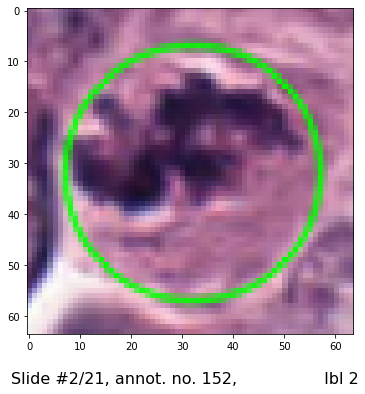

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

40 of 64 patches subclassed; 24 left to go!



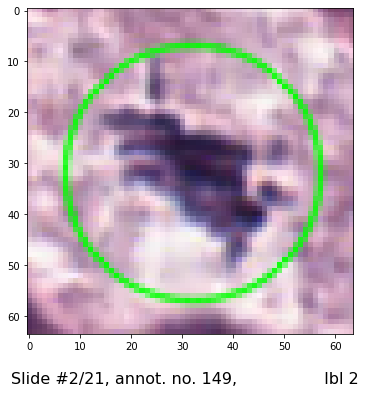

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

41 of 64 patches subclassed; 23 left to go!



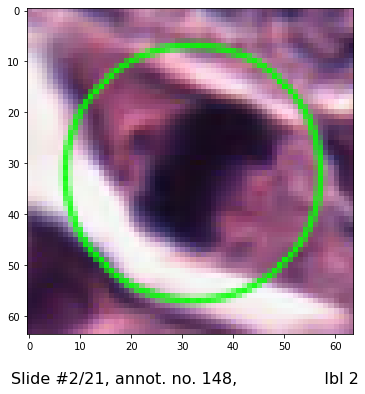

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

42 of 64 patches subclassed; 22 left to go!



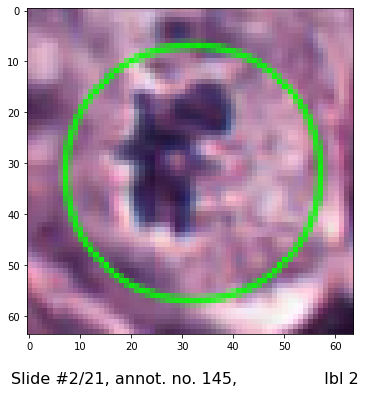

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

43 of 64 patches subclassed; 21 left to go!



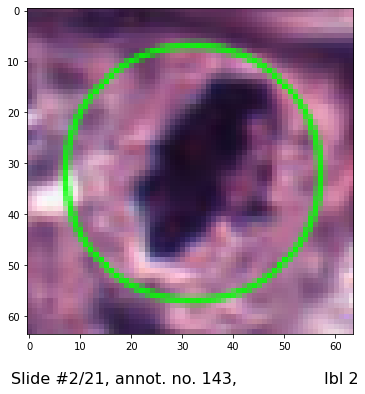

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

44 of 64 patches subclassed; 20 left to go!



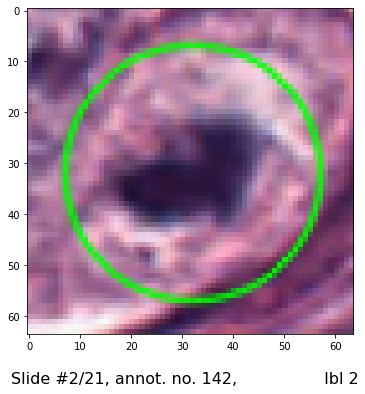

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

45 of 64 patches subclassed; 19 left to go!



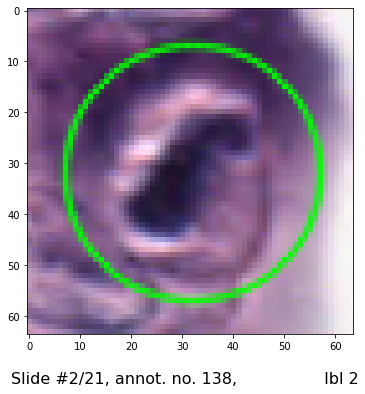

Subclass label?  0


OK, confirming user subclass label =    0 written to annotation dataframe....

46 of 64 patches subclassed; 18 left to go!



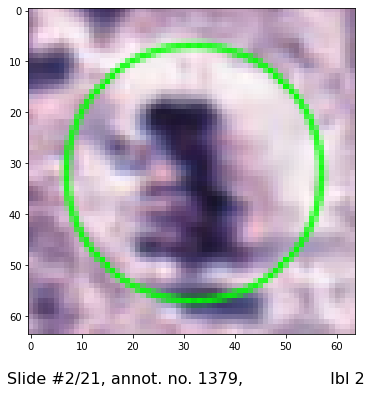

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

47 of 64 patches subclassed; 17 left to go!



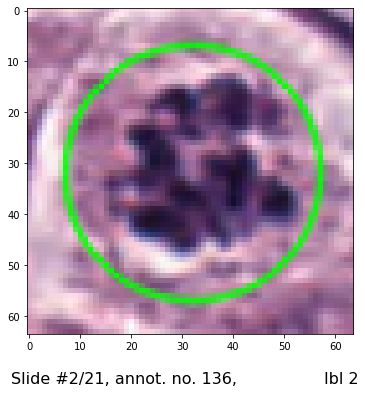

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

48 of 64 patches subclassed; 16 left to go!



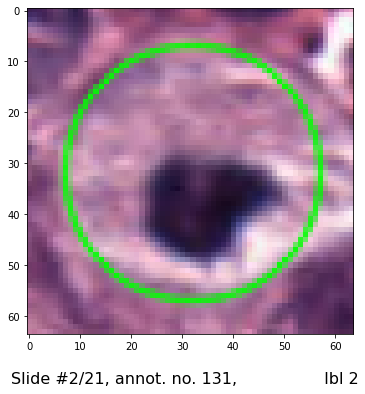

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

49 of 64 patches subclassed; 15 left to go!



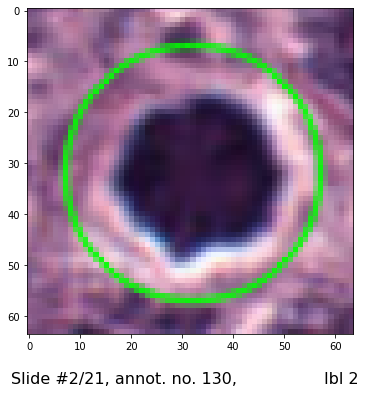

Subclass label?  3


OK, confirming user subclass label =    3 written to annotation dataframe....

50 of 64 patches subclassed; 14 left to go!



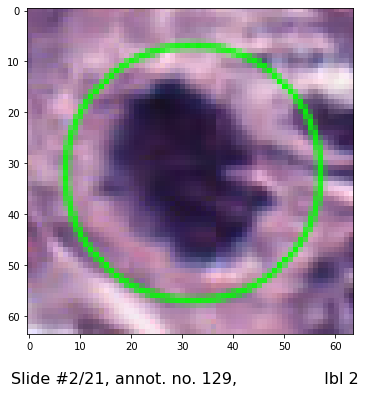

Subclass label?  3


OK, confirming user subclass label =    3 written to annotation dataframe....

51 of 64 patches subclassed; 13 left to go!



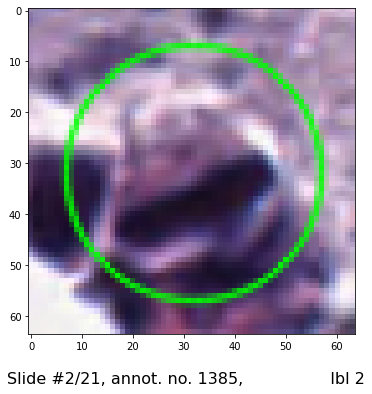

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

52 of 64 patches subclassed; 12 left to go!



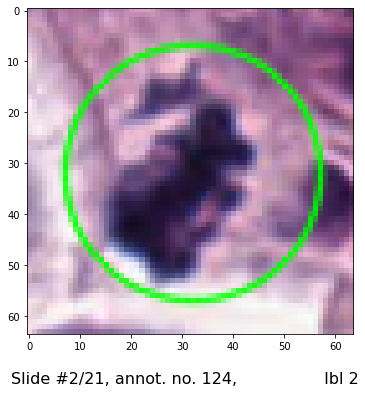

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

53 of 64 patches subclassed; 11 left to go!



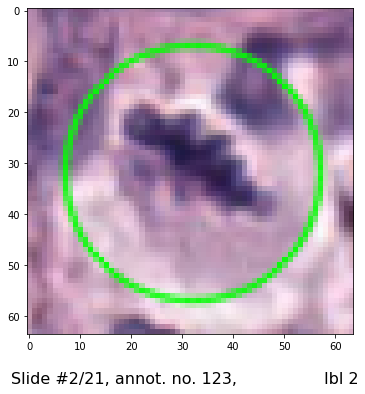

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

54 of 64 patches subclassed; 10 left to go!



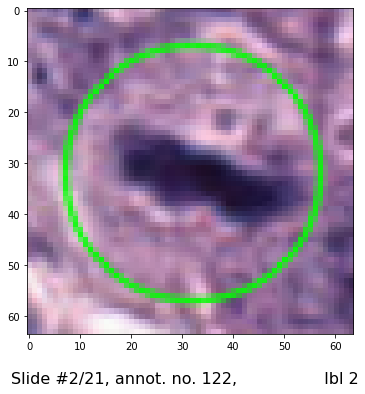

Subclass label?  4


OK, confirming user subclass label =    4 written to annotation dataframe....

55 of 64 patches subclassed; 9 left to go!



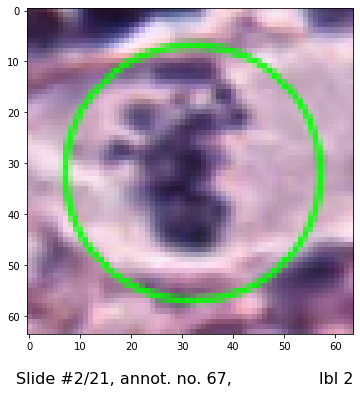

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

56 of 64 patches subclassed; 8 left to go!



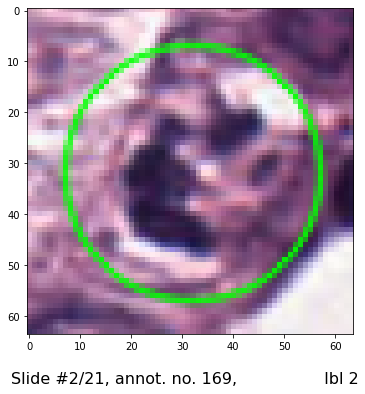

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

57 of 64 patches subclassed; 7 left to go!



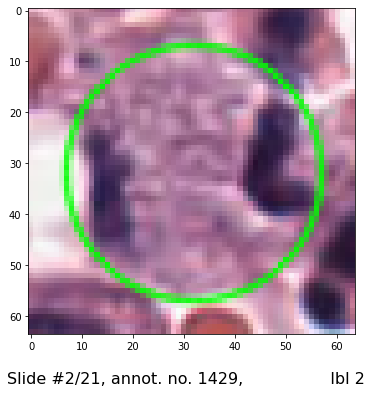

Subclass label?  6


OK, confirming user subclass label =    6 written to annotation dataframe....

58 of 64 patches subclassed; 6 left to go!



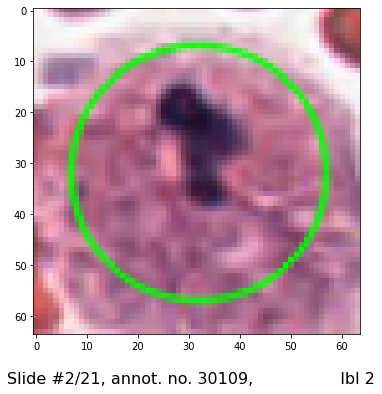

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

59 of 64 patches subclassed; 5 left to go!



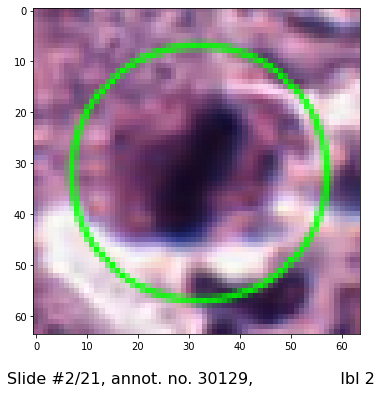

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

60 of 64 patches subclassed; 4 left to go!



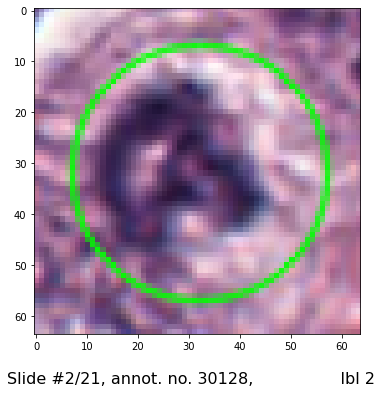

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

61 of 64 patches subclassed; 3 left to go!



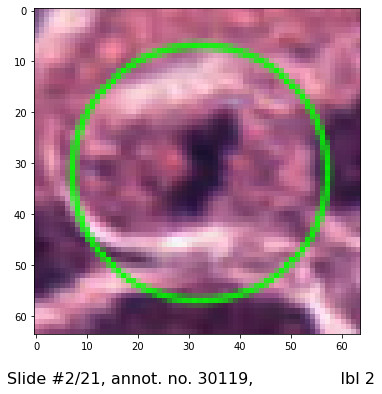

Subclass label?  7


OK, confirming user subclass label =    7 written to annotation dataframe....

62 of 64 patches subclassed; 2 left to go!



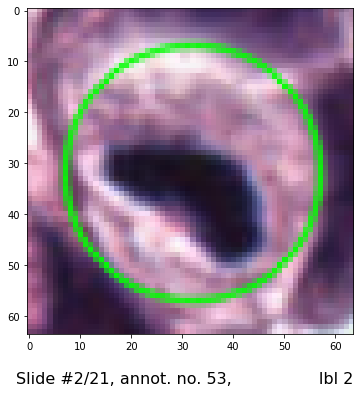

Subclass label?  0


OK, confirming user subclass label =    0 written to annotation dataframe....

63 of 64 patches subclassed; 1 left to go!



In [ ]:
# let's subclass some MF's:
from SlideRunner.dataAccess.annotations import ViewingProfile
import matplotlib.pyplot as plt
import numpy as np

# prepare for looping through patches & requesting subclass label:

# set patch pixel dim:
pix_dim = 64

# set arguments for requesting user subclass label input using read_val fxn:
request_msg = 'Subclass label? '
error_msg = 'Not a valid subclass label; please retry....\n'
val_range = [3,4,5,6,7,8,0]    # subclass labels must be 3,4,5,6,7,8, or 0

# add a 'subcl' column to df to hold subclass labels (if it doesn't exist), and
# fill with int(0), which is the label for 'ambiguous/skip'; so by default, none
# of the patches will be used unless their subclass label has been specifically
# changed during viewing and subclassing!
annot_df_sorted['subcl'] = annot_df_sorted.get('subcl', int(0))

# loop through MFs in annot_df_sorted, asking for user subclass label:
for mf in range(len(annot_cl2_l)):
    # verify annot. is CLASS2 (MF):
    assert int(annot_df_sorted.iat[mf, 4]) == 2

    # verify annot. key = annot. uid
    assert int(annot_df_sorted.iat[mf, 0]) == int(annot_df_sorted.iat[mf, 1])
                                                   
    # use annot. uid
    annot_no = int(annot_df_sorted.iat[mf, 1])   
    
    # get coord. of LU corner bb of dim pix_dim centered about annot.:                                
    LUx = int(int(annot_df_sorted.iat[mf, 2][0]) - pix_dim/2)
    LUy = int(int(annot_df_sorted.iat[mf, 2][1]) - pix_dim/2)
    lu  = (LUx, LUy)

    # get image patch & display:
    img = np.array(slide.read_region(lu, 0, [pix_dim, pix_dim]))[:,:,0:4]
    DB.annotations[annot_no].draw(image=img, leftUpper=lu, zoomLevel=1., 
                                  thickness=1, vp=ViewingProfile())
    
    caption = f'Slide #{slide_no}/21, annot. no. {annot_no}, \
                lbl {DB.annotations[annot_no].agreedClass}'
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.figtext(0.5, 0.01, caption, wrap=False, horizontalalignment='center', 
                fontsize=16)
    plt.show()

    # ask user for subclass label:
    subclass_label = read_val(int, val_range, request_msg, error_msg)

    # write user label to df:
    annot_df_sorted.iat[mf, 6] = subclass_label
    print(f'\n\nOK, confirming user subclass label = {subclass_label:4d} '
          f'written to annotation dataframe....\n\n'
          f'{mf} of {len(annot_cl2_l)} patches subclassed; '
          f'{len(annot_cl2_l)-mf} left to go!\n')

In [ ]:
# look at annot_df_sorted after completing subclassing all MFs on this slide:
annot_df_sorted

<IPython.core.display.Javascript object>

,key,uid,ctr,coord,lbl,guid,subcl
134,144,144,"[39154, 38931]","[[39129, 38906], [39179, 38956]]",2,55769705-b5df-4669-bd4a-6abb782c05e9,4
110,116,116,"[41841, 35854]","[[41816, 35829], [41866, 35879]]",2,37da286e-c719-4e2e-8c28-5106279c8745,7
104,109,109,"[43709, 35008]","[[43684, 34983], [43734, 35033]]",2,aac4e2fa-c1ad-42f4-b139-c9b7d5b3696b,7
188,1396,1396,"[14790, 34067]","[[14765, 34042], [14815, 34092]]",2,47118562-d433-49d2-9c72-b0c1fa5242ea,4
101,106,106,"[23996, 35202]","[[23971, 35177], [24021, 35227]]",2,d819ba1a-ff85-40bd-8e39-faf42117c8a4,7
100,105,105,"[14293, 34679]","[[14268, 34654], [14318, 34704]]",2,8d2b7434-407e-4d3f-b61b-fceb0b27d5c6,7
99,104,104,"[11166, 35831]","[[11141, 35806], [11191, 35856]]",2,7e538efe-7c4c-4f7b-8f22-c10d61c27366,7
98,103,103,"[11153, 35690]","[[11128, 35665], [11178, 35715]]",2,6a856710-6ab3-4807-99cb-659e8b9d6ae3,7
97,102,102,"[10910, 35820]","[[10885, 35795], [10935, 35845]]",2,2c7ad1c8-1293-4a4b-b651-9335d438fbb3,7
94,99,99,"[7746, 34679]","[[7721, 34654], [7771, 34704]]",2,0b1511e8-a58e-4e54-9265-65ac68d9c5de,6


### ___NB: No corrections needed so didn't run the following 2 cells...___

In [ ]:
# correct annot. 18208
# first print this df row as is:
annot_df_sorted.loc[annot_df_sorted['key']==18208]

In [ ]:
# # now, correct annotID 116 from subclass 6 to subclass 7 (AMF):
# annot_df_sorted.iloc[1,6] = int(7)
# 
# # finally, confirmed change:
# annot_df_sorted

# ___Finally, write the df w/ all MFs from slide 2 subclassed to csv:___

In [ ]:
# write above df w/ MFs subclassed to csv:
# import time
# timestr = time.strftime("%Y%m%d-%H%M%S")

annot_df_sorted.to_csv('drive/MyDrive/sam/subcl/slide_2/' +
                '20221116-115200' + '_ann_df_subcl_slide_no_' + str(slide_no) + '_all_64_MFs.csv')

<IPython.core.display.Javascript object>

# ___★ NB: This slide_2 subclassing notebook ends here (ignore below)!★___  
---  
---  
---  


 
 ~~_NB: Had to write the annot_df_sorted to .csv before making the correction in annotation 18208 due to time constraints (given subclass label 6, but should be changed to 4):_  ~~

~~_Will now reload the above .csv into pandas, make the correction, and save it back:_~~~


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# generate time stamp for corrected .csv file:
import time
timestr = time.strftime("%-y%-d%-m-%-S%-M%-H")

In [ ]:
# load .csv from google drive for correction:
import pandas as pd

annot_df_sorted = pd.read_csv(
    'drive/MyDrive/sam/subcl/slide_5/221211-273415_ann_df_subcl_slide_no_5_all_130_MFs.csv',
    index_col=[0])    # this reads in the .csv using the values in col 1 as pd df index

In [ ]:
annot_df_sorted.head(50)

~~#### _(above verified with original notebook copy of annot_df_sorted before .csv export)_~~

In [ ]:
# correct annot. 18208
# first print this df row as is:
annot_df_sorted.loc[annot_df_sorted['key']==18208]

In [ ]:
# now make correction in above annotation row:
annot_df_sorted.loc[annot_df_sorted['key']==18208, 'subcl'] = int(4)

# verify correction:
annot_df_sorted.loc[annot_df_sorted['key']==18208]

In [ ]:
# take a look at annot_df_sorted df:
annot_df_sorted

In [ ]:
# looks good;
# (re)-write above corrected df w/ MFs subclassed to csv:

annot_df_sorted.to_csv('drive/MyDrive/sam/subcl/slide_5/' +
                timestr + '_ann_df_subcl_CORRECTED_sl_5_all_130_MFs.csv')